In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("ETTh1.csv")

In [3]:
print(df['date'])

0        2016-07-01 00:00:00
1        2016-07-01 01:00:00
2        2016-07-01 02:00:00
3        2016-07-01 03:00:00
4        2016-07-01 04:00:00
                ...         
17415    2018-06-26 15:00:00
17416    2018-06-26 16:00:00
17417    2018-06-26 17:00:00
17418    2018-06-26 18:00:00
17419    2018-06-26 19:00:00
Name: date, Length: 17420, dtype: object


In [4]:
print(df.info())  # check data types and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17420 entries, 0 to 17419
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    17420 non-null  object 
 1   HUFL    17420 non-null  float64
 2   HULL    17420 non-null  float64
 3   MUFL    17420 non-null  float64
 4   MULL    17420 non-null  float64
 5   LUFL    17420 non-null  float64
 6   LULL    17420 non-null  float64
 7   OT      17420 non-null  float64
dtypes: float64(7), object(1)
memory usage: 1.1+ MB
None


#### As it can be seen there is no missing value

In [5]:
print(df.describe())  # Getting summary statistics

               HUFL          HULL          MUFL          MULL          LUFL  \
count  17420.000000  17420.000000  17420.000000  17420.000000  17420.000000   
mean       7.375141      2.242242      4.300239      0.881568      3.066062   
std        7.067744      2.042342      6.826978      1.809293      1.164506   
min      -22.705999     -4.756000    -25.087999     -5.934000     -1.188000   
25%        5.827000      0.737000      3.296000     -0.284000      2.315000   
50%        8.774000      2.210000      5.970000      0.959000      2.833000   
75%       11.788000      3.684000      8.635000      2.203000      3.625000   
max       23.643999     10.114000     17.341000      7.747000      8.498000   

               LULL            OT  
count  17420.000000  17420.000000  
mean       0.856932     13.324672  
std        0.599552      8.566946  
min       -1.371000     -4.080000  
25%        0.670000      6.964000  
50%        0.975000     11.396000  
75%        1.218000     18.079000  


In [6]:
print(df.columns)

Index(['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')


In [7]:
from sklearn.preprocessing import MinMaxScaler

# Select numerical columns (exclude 'date')
time_series_data = df.drop(columns=['date'])

# Normalize the data for better clustering performance
scaler =  MinMaxScaler()
#print(scaler)
normalized_data = scaler.fit_transform(time_series_data)
#print(normalized_data.head())

In [8]:
print(time_series_data.columns)

Index(['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')


In [9]:
print(time_series_data.head())

    HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4  5.358  1.942  1.492  0.462  3.868  1.279  21.948000


In [10]:
print(normalized_data.shape)

(17420, 7)


In [11]:
print(time_series_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17420 entries, 0 to 17419
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HUFL    17420 non-null  float64
 1   HULL    17420 non-null  float64
 2   MUFL    17420 non-null  float64
 3   MULL    17420 non-null  float64
 4   LUFL    17420 non-null  float64
 5   LULL    17420 non-null  float64
 6   OT      17420 non-null  float64
dtypes: float64(7)
memory usage: 952.8 KB
None


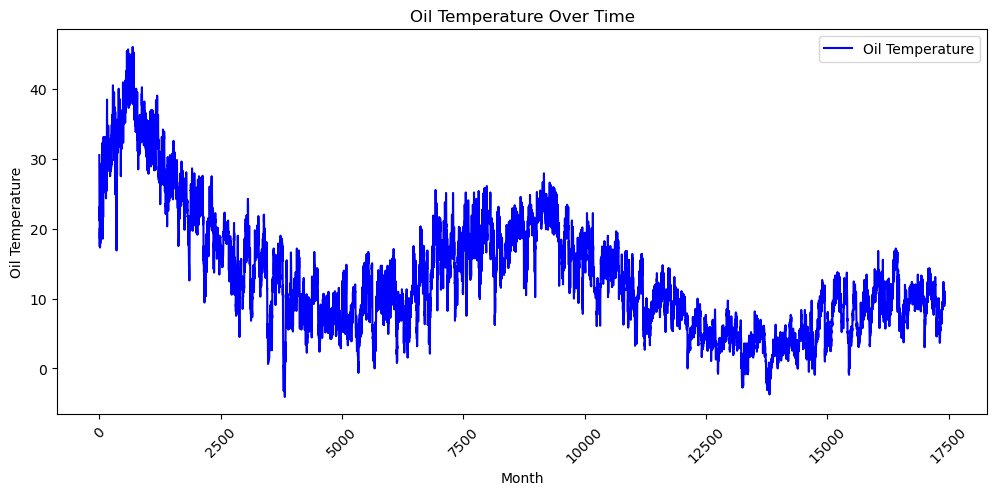

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['OT'], color='blue', label="Oil Temperature") 

plt.xlabel("Month")
plt.ylabel("Oil Temperature")
plt.title("Oil Temperature Over Time")
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.show()

In [20]:
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist
from collections import defaultdict
import pandas as pd

class ConnectedMixtureComponents:
    def __init__(self, n_components=4, window_size=168, step_size=24, epsilon=1.0):
        """
        Robust implementation of connected mixture components with accurate tracking
        
        Parameters:
        - n_components: Number of Gaussian components
        - window_size: Size of each time window (in observations)
        - step_size: Sliding window step size
        - epsilon: Maximum distance for component connections
        """
        self.n_components = n_components
        self.window_size = window_size
        self.step_size = step_size
        self.epsilon = epsilon
        self.window_params_ = None
        self.component_tracks_ = None
        self.n_features_ = None

    def fit_transform(self, X):
        """Main processing pipeline with strict boundary checking"""
        # Input validation and conversion
        if isinstance(X, pd.DataFrame):
            X = X.values
        elif not isinstance(X, np.ndarray):
            X = np.array(X)
            
        # Ensure 2D array
        self.n_features_ = X.shape[1] if X.ndim > 1 else 1
        if X.ndim == 1:
            X = X.reshape(-1, 1)
            
        # Create windows and fit GMMs
        windows = self._create_windows(X)
        self.window_params_ = [self._fit_gmm(window) for window in windows]
        
        # Connect components with strict validation
        self.component_tracks_ = self._connect_components(self.window_params_)
        
        # Create features with bounds checking
        return self._create_features(self.window_params_)
        
    def _create_windows(self, X):
        """Create sliding windows with validation"""
        n_samples = X.shape[0]
        if n_samples < self.window_size:
            raise ValueError(f"Data length ({n_samples}) is shorter than window_size ({self.window_size})")
            
        num_windows = (n_samples - self.window_size) // self.step_size + 1
        print(f"Created {num_windows} windows from {n_samples} samples")
        
        return [X[i*self.step_size:i*self.step_size+self.window_size] 
                for i in range(num_windows)]

    def _fit_gmm(self, window):
        """Fit GMM with validation checks"""
        if len(window) < self.n_components:
            n_components = min(len(window), self.n_components)
            print(f"Reducing n_components to {n_components} for window with {len(window)} samples")
        else:
            n_components = self.n_components
            
        gmm = GaussianMixture(n_components=n_components, 
                             covariance_type='diag',
                             random_state=42)
        gmm.fit(window)
        
        return {
            'means': gmm.means_,
            'stds': np.sqrt(gmm.covariances_),
            'weights': gmm.weights_,
            'labels': gmm.predict(window)
        }

    def _connect_components(self, window_params):
        """Connect components with strict boundary enforcement"""
        tracks = defaultdict(list)
        next_id = 0
        total_windows = len(window_params)
        
        # Initialize first window if it exists
        if total_windows > 0 and len(window_params[0]['means']) > 0:
            for i in range(min(self.n_components, len(window_params[0]['means']))):
                tracks[next_id].append((0, i))
                next_id += 1
        
        # Process subsequent windows
        for t in range(1, total_windows):
            prev_params = window_params[t-1]
            curr_params = window_params[t]
            
            # Skip empty windows
            if len(curr_params['means']) == 0 or len(prev_params['means']) == 0:
                continue
                
            # Calculate distances between components
            prev_features = np.hstack([prev_params['means'], prev_params['stds']])
            curr_features = np.hstack([curr_params['means'], curr_params['stds']])
            dists = cdist(prev_features, curr_features, 'euclidean')
            
            # Find valid connections
            connections = set()
            for i in range(len(prev_params['means'])):
                for j in range(len(curr_params['means'])):
                    if dists[i,j] < self.epsilon:
                        connections.add((i,j))
            
            # Update existing tracks
            used_new = set()
            active_tracks = {}
            
            for comp_id, track in list(tracks.items()):
                if not track:
                    continue
                    
                last_win, last_comp = track[-1]
                if last_win == t-1 and last_comp < len(prev_params['means']):
                    for (i,j) in connections:
                        if i == last_comp and j < len(curr_params['means']):
                            track.append((t, j))
                            used_new.add(j)
                            active_tracks[comp_id] = True
            
            # Create new tracks for unconnected components
            for j in range(len(curr_params['means'])):
                if j not in used_new:
                    tracks[next_id].append((t, j))
                    next_id += 1
        
        # Final validation pass
        valid_tracks = defaultdict(list)
        for comp_id, track in tracks.items():
            valid_track = []
            for win, comp in track:
                if (win < total_windows and 
                    comp < len(window_params[win]['means'])):
                    valid_track.append((win, comp))
            
            if len(valid_track) > 0:
                valid_tracks[comp_id] = valid_track
                
        return valid_tracks

    def _create_features(self, window_params):
        """Create feature series with proper dimensionality handling"""
        features = []
        total_windows = len(window_params)
    
        for comp_id, track in self.component_tracks_.items():
            comp_series = []
            for win, comp in track:
                if (win < total_windows and 
                    comp < len(window_params[win]['means'])):
                    params = window_params[win]
                    # Ensure proper dimensions
                    means = params['means'][comp].reshape(1, -1)  # Shape (1, n_features)
                    stds = params['stds'][comp].reshape(1, -1)    # Shape (1, n_features)
                    weight = np.array([[params['weights'][comp]]]) # Shape (1, 1)
                
                    # Combine with proper dimensions
                    feature_row = np.hstack([means, stds, weight])  # Shape (1, n_features*2 + 1)
                    comp_series.append(feature_row[0])  # Get the single row
        
            if len(comp_series) > 0:
                features.append(np.array(comp_series))
    
        return np.array(features, dtype=object) if features else np.array([])

    def get_component_stats(self):
        """Generate accurate component statistics with full validation"""
        if not hasattr(self, 'component_tracks_'):
            raise ValueError("Must call fit_transform() first")
            
        stats = []
        total_windows = len(self.window_params_)
        
        for comp_id, track in self.component_tracks_.items():
            # Filter to only valid window-component pairs
            valid_track = []
            for win, comp in track:
                if (win < total_windows and 
                    comp < len(self.window_params_[win]['means'])):
                    valid_track.append((win, comp))
            
            if not valid_track:
                continue
                
            duration = len(valid_track)
            start = valid_track[0][0]
            end = valid_track[-1][0]
            
            # Calculate actual statistics
            means = []
            stds = []
            weights = []
            
            for win, comp in valid_track:
                params = self.window_params_[win]
                means.append(params['means'][comp])
                stds.append(params['stds'][comp])
                weights.append(params['weights'][comp])
            
            stats.append({
                'component_id': comp_id,
                'duration_windows': duration,
                'start_window': start,
                'end_window': end,
                'mean_values': np.mean(means, axis=0),  # Array of means per feature
                'mean_stds': np.mean(stds, axis=0),     # Array of stds per feature
                'mean_weight': np.mean(weights),
                'time_span': duration * self.step_size,
                'is_active': (end == total_windows - 1)  # Still active at end
            })
        
        if not stats:
            return pd.DataFrame()
            
        stats_df = pd.DataFrame(stats)
        
        # Calculate relative durations
        max_duration = stats_df['duration_windows'].max()
        stats_df['relative_duration'] = stats_df['duration_windows'] / max_duration
        
        # Sort by duration
        return stats_df.sort_values('duration_windows', ascending=False)

    def plot_component_stats(self):
        """Visualize component statistics"""
        stats = self.get_component_stats()
        if len(stats) == 0:
            print("No components to plot")
            return
            
        plt.figure(figsize=(12, 6))
        
        # Duration distribution
        plt.subplot(1, 2, 1)
        stats['duration_windows'].hist(bins=20)
        plt.title('Component Duration Distribution')
        plt.xlabel('Duration (windows)')
        plt.ylabel('Count')
        
        # Duration vs Start time
        plt.subplot(1, 2, 2)
        plt.scatter(stats['start_window'], stats['duration_windows'],
                   c=stats['mean_weight'], cmap='viridis')
        plt.colorbar(label='Mean Weight')
        plt.title('Duration vs Start Window')
        plt.xlabel('Start Window')
        plt.ylabel('Duration')
        
        plt.tight_layout()
        plt.show()

Created 719 windows from 17420 samples
   component_id  duration_windows  start_window  end_window  \
0             0              2355             0         718   
3             3              2355             0         718   
1             1              2355             0         718   
2             2              2355             0         718   
4             4              2244            28         718   

                                         mean_values  \
0  [0.6520579042925438, 0.47632280024993134, 0.69...   
3  [0.6520726810381605, 0.47633713677711376, 0.69...   
1  [0.6520054349385962, 0.47625269016898636, 0.69...   
2  [0.6520477967482131, 0.4763051170103539, 0.695...   
4  [0.6462925348507388, 0.4726474064345247, 0.689...   

                                           mean_stds  mean_weight  time_span  \
0  [0.04355603435312768, 0.047460106083514544, 0....     0.257721      56520   
3  [0.043559515839705354, 0.04746263056366275, 0....     0.257719      56520   
1  [0

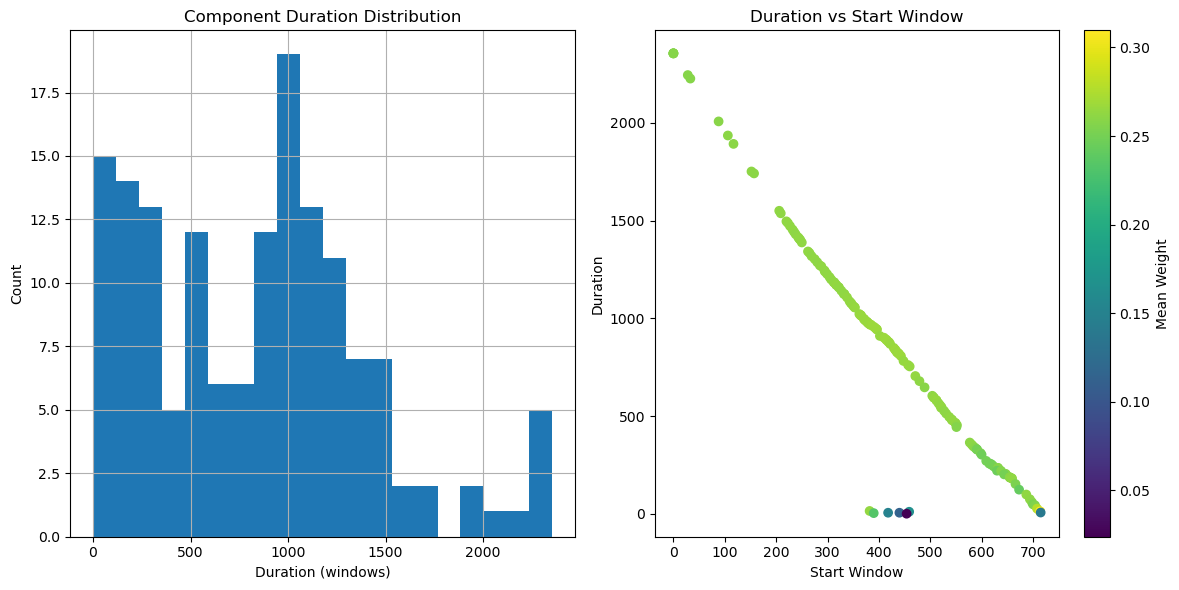

Component 0 appeared in 2355 windows
Component 1 appeared in 2355 windows
Component 2 appeared in 2355 windows
Component 3 appeared in 2355 windows
Component 4 appeared in 2244 windows
Component 5 appeared in 2226 windows
Component 6 appeared in 2007 windows
Component 7 appeared in 1935 windows
Component 8 appeared in 1892 windows
Component 9 appeared in 1751 windows
Component 10 appeared in 1741 windows
Component 11 appeared in 1550 windows
Component 12 appeared in 1537 windows
Component 13 appeared in 1496 windows
Component 14 appeared in 1487 windows
Component 15 appeared in 1472 windows
Component 16 appeared in 1454 windows
Component 17 appeared in 1442 windows
Component 18 appeared in 1430 windows
Component 19 appeared in 1414 windows
Component 20 appeared in 1407 windows
Component 21 appeared in 1401 windows
Component 22 appeared in 1388 windows
Component 23 appeared in 1342 windows
Component 24 appeared in 1334 windows
Component 25 appeared in 1318 windows
Component 26 appeared 

In [21]:
if isinstance(normalized_data, pd.DataFrame):
    X = normalized_data[['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']].values
# If it's already a numpy array:
elif isinstance(normalized_data, np.ndarray):
    X = normalized_data
else:
    raise ValueError("normalized_data must be either pandas DataFrame or numpy array")

# Initialize with your parameters
cmc = ConnectedMixtureComponents(
    n_components=4,
    window_size=168,
    step_size=24,
    epsilon=0.5
)

# Process your data
features = cmc.fit_transform(X)

# Get accurate statistics
stats = cmc.get_component_stats()
print(stats.head())

# Visualize results
cmc.plot_component_stats()

# Access individual component tracks
for comp_id, track in cmc.component_tracks_.items():
    print(f"Component {comp_id} appeared in {len(track)} windows")